- One timestep represents 5 days
- Civil patients take 42/5=8 timesteps to treat
- Forensic patients take 118/4=24 timesteps to treat
- A quarter is 90 days, 90/5=18 steps
- After being primed, the model runs from Q1 of 2020 to Q4 of 2022 
- 12 quarters times 18 steps per quarter is 216 steps
- forensic admits are estimated with linear regression

INFO added 11/30/23 - mean 

In [2]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import math
import keras
import scipy
from sklearn.linear_model import LinearRegression
from dataclasses import dataclass

2023-09-01 15:19:35.709132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Estimate the distribution of length of stay (los), agnostic to patient type (civil, short-term forensic, long-term forensic)

INFO added 11/30/23 - these numbers come from average daily census and average length of stay per hospital as reported in https://www.lbb.texas.gov/Documents/Publications/Primer/6279_State_Hospitals_Primer.pdf

In [3]:
los_set = [203*[208], 127*[301], 43*[72], 199*[1640], 222*[234], 210*[159], 48*[38], 228*[399], 200*[281], 209*[76]]

In [4]:
los_set = [num for sublist in los_set for num in sublist]

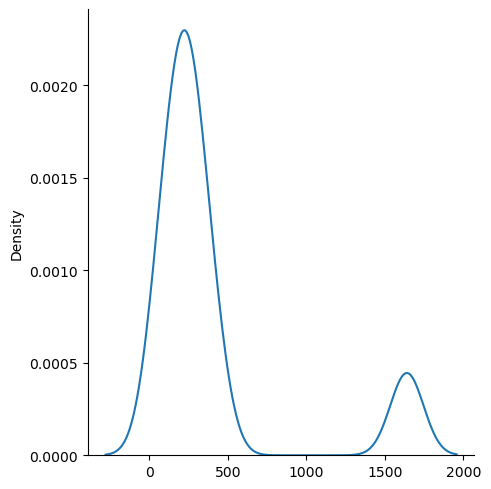

In [5]:
sns.displot(los_set, kind="kde")

Estimate the number of forensic admits at each time step

In [6]:
quarters_1D = np.array([0, 18, 36, 54, 72, 90, 108, 126, 180, 198])
quarters = np.array([0, 18, 36, 54, 72, 90, 108, 126, 180, 198]).reshape((-1, 1))
forensic_admits = np.array([605/18, 577/18, 502/18, 482/18, 509/18, 436/18, 572/18, 564/18, 574/18, 566/18])
forensic_waitlist_len = np.array([500, 451, 351, 299, 842, 889, 924, 1037, 1481, 1526])
steps_inputs = np.array(range(0, 216, 1))

In [19]:
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

model.fit( quarters, forensic_admits, epochs=1000, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
 dense_9 (Dense)             (None, 64)                128       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,355
Trainable params: 4,355
Non-trainable params: 0
_________________________________________________________________


In [20]:
y_predicted = model.predict(steps_inputs)

7/7 [==============================] - 0s 1ms/step


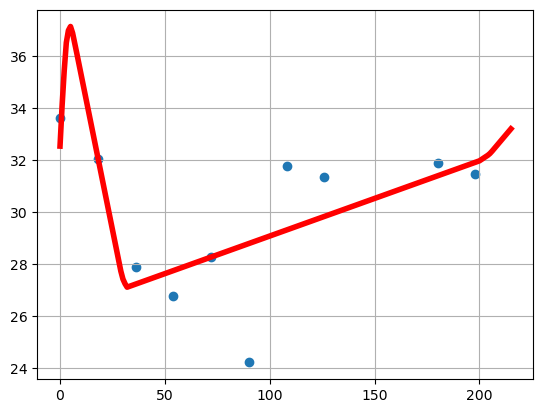

In [21]:
plt.scatter(quarters[::1], forensic_admits[::1])
plt.plot(steps_inputs, y_predicted, 'r', linewidth=4)
plt.grid()
plt.show()

In [22]:
forensic_admits_imputed = np.round(y_predicted) 

Estimate the forensic waitlist at each timestep

In [11]:
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

model.fit(quarters, forensic_waitlist_len, epochs=1000, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
 dense_5 (Dense)             (None, 64)                128       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,355
Trainable params: 4,355
Non-trainable params: 0
_________________________________________________________________


In [12]:
waitlist_imputed = model.predict(steps_inputs)

7/7 [==============================] - 0s 1ms/step


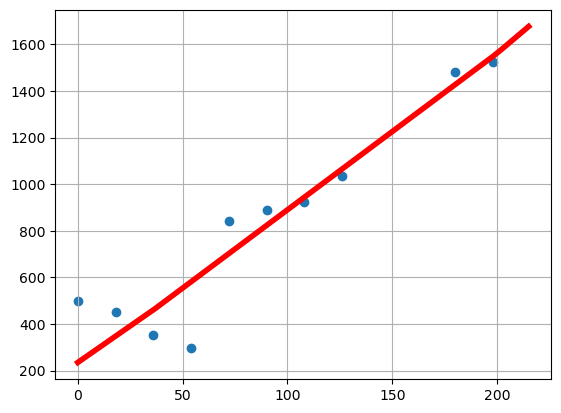

In [13]:
plt.scatter(quarters[::1], forensic_waitlist_len[::1])
plt.plot(steps_inputs, waitlist_imputed, 'r', linewidth=4)
plt.grid()
plt.show()

Variables to find: 
- likelihood of relapse at each step for stable patients (one for civic, one for forensic)
- three normal distributions of treatment times for civil, short term forensic, and long term forensic patients
- proportion of short term forensic to long term forensic patients

In [14]:
@dataclass
class Agent:
    AgentID: int
    Civil: int
    Forensic: int
    TreatmentTime: float
    #ProbRelapse: float
    AgentHistory: []
    State_Untreated: int = 1
    State_Waitlisted: int = 0
    State_InTreatment: int = 0
    State_Stable: int = 0
    TreatmentCenterID: int = -1
    ProbSeekTreatment: float = 0.2
        
@dataclass
class TreatmentCenter:
    TreatID: int
    Online_Capacity: int
    Max_Capacity: int
    waitlist: []
    waitlistHistory: []
    Current_Population: int = 0
        
def TimeStep_Agents(AgentArray, TreatCent_Array, patientChoice):
    
    for Agent in AgentArray:
        if(Agent.State_Untreated == 1): #Untreated patients now enter the waitlist immediately.  
            #if(Agent.Civil==1):
            #    changeState = np.random.choice([1, 0], size=(1,), p=[0.2, 0.8])
            #    if(changeState == 0): # Civil patient is declining treatment
            #        Agent.AgentHistory.append(-1)
            #        continue
            if(patientChoice == 'random'):
                min_cost_center = pickTreatmentCenterRandomly(TreatCent_Array) # Lowest cost center (LCC) is identified
                TreatCent_Array[min_cost_center].waitlist.insert(0, Agent.AgentID) # Add patient to the LCC waitlist
                Agent.State_Untreated = 0
                Agent.State_Waitlisted = 1 # Update patient state variable to "waitlisted"
                Agent.AgentHistory.append(-2)
                Agent.TreatmentCenterID = min_cost_center # Update affiliated treatment center with LCC index
            elif(patientChoice == 'cost'):
                min_cost_center = pickTreatmentCenterFromCost(TreatCent_Array) # Lowest cost center (LCC) is identified
                TreatCent_Array[min_cost_center].waitlist.insert(0, Agent.AgentID) # Add patient to the LCC waitlist
                Agent.State_Untreated = 0
                Agent.State_Waitlisted = 1 # Update patient state variable to "waitlisted"
                Agent.AgentHistory.append(-2)
                Agent.TreatmentCenterID = min_cost_center # Update affiliated treatment center with LCC index
        elif(Agent.State_InTreatment == 1): #Patient is in treatment, what happens next?
            lifespan = len(Agent.AgentHistory)
            time_t=0
            while(lifespan > 0):
                if(Agent.AgentHistory[-(time_t+1)] > -1):
                    time_t = time_t+1
                    lifespan = lifespan-1
                else:
                    break
            if(time_t < Agent.TreatmentTime):
                changeState=2
            else:
                changeState=0
            if(changeState == 0): # Patient is successfully discharged
                Agent.State_InTreatment = 0
                Agent.State_Stable = 1
                Agent.AgentHistory.append(-4)
                TreatCent_Array[Agent.TreatmentCenterID].Current_Population = TreatCent_Array[Agent.TreatmentCenterID].Current_Population-1 # update treatment center
            if(changeState == 2): # Patient stays in treatment
                Agent.AgentHistory.append(Agent.AgentHistory[-1])
        elif(Agent.State_Waitlisted == 1): # Patient is waitlisted - we just need to update their history
            #add baulking option for civil admits here
            Agent.AgentHistory.append(-2)
        elif(Agent.State_Stable == 1):
            # add relapse options here
            Agent.AgentHistory.append(-4)

def TimeStep_TreatmentCenters(TreatmentCenterArray, Agent_Array, patientChoice):
    for TreatmentCenter in TreatmentCenterArray:
        while(TreatmentCenter.Current_Population < TreatmentCenter.Online_Capacity and len(TreatmentCenter.waitlist)>0): # if there are open beds
            if(len(TreatmentCenter.waitlist) > 0): # if there are patients on the waitlist
                enrollee_id = TreatmentCenter.waitlist.pop()
                for agent in Agent_Array:
                    if agent.AgentID==enrollee_id:
                        agent.State_Waitlisted=0
                        agent.State_InTreatment=1
                        agent.AgentHistory[-1] = TreatmentCenter.TreatID
                TreatmentCenter.Current_Population = TreatmentCenter.Current_Population + 1
        TreatmentCenter.waitlistHistory.append(len(TreatmentCenter.waitlist))
                
def GetAllWaitTimes(AgentArray):
    
    lengthWaitTimes = []
    for Agent in AgentArray:
        history = Agent.AgentHistory
        currentWaitLength = 0
        hospitalized = False
        for i in np.arange(len(Agent.AgentHistory)):
            if(Agent.AgentHistory[i] == -2): # Patient is on a waitlist
                currentWaitLength = currentWaitLength+1
            if(Agent.AgentHistory[i] >= 0): # Patient is hospitalized
                if(hospitalized == False): # First "day" of hospitalization
                    lengthWaitTimes.append(currentWaitLength)
                    currentWaitLength = 0
                    hospitalized = True
    return lengthWaitTimes

def GetTotalTimesToCured(AgentArray):
        
    lengthCureTimes = []
    for Agent in AgentArray:
        time = 0
        for i in np.arange(len(Agent.AgentHistory)):
            if(Agent.AgentHistory[i] != -4):
                time = time + 1
            else:
                lengthCureTimes.append(time)
                break;       
    return lengthCureTimes

def GetTimesFromSeekToCured(AgentArray):
    
    lengthCureTimes = []
    for Agent in AgentArray:
        SeekPriorTreatment = False
        time = 0;
        for i in np.arange(len(Agent.AgentHistory)):
            if(Agent.AgentHistory[i] != -1 and SeekPriorTreatment == False): # First time seeking treatment
                time = time + 1;
                SeekPriorTreatment = True
            elif(Agent.AgentHistory[i] != -4 and SeekPriorTreatment == True):
                time = time + 1
            elif(Agent.AgentHistory[i] == -4 and SeekPriorTreatment == True):
                lengthCureTimes.append(time)
                break;        
    return lengthCureTimes

def getNumberofTimesTreated(AgentArray):

    numTimesTreated = []
    for Agent in AgentArray:
        timesTreated = 0
        inTreatment = False
        for i in np.arange(len(Agent.AgentHistory)):
            if(Agent.AgentHistory[i] >= 0 and inTreatment == False):
                timesTreated = timesTreated + 1
                inTreatment = True
            elif(Agent.AgentHistory[i] < 0 and inTreatment == True):
                inTreatment = False      
        numTimesTreated.append(timesTreated)
    return numTimesTreated

def pickTreatmentCenterFromCost(TreatCent_Array):

    TreatCentCost = []
    for i in range(0, len(TreatCent_Array)):
        cost = len(TreatCent_Array[i].waitlist)/TreatCent_Array[i].Online_Capacity
        TreatCentCost.append(cost)
    min_cost = min(TreatCentCost)
    min_cost_center = TreatCentCost.index(min_cost) # Lowest cost center (LCC) is identified
    return min_cost_center
    
def pickTreatmentCenterRandomly(TreatCent_Array):
        
    treatcent_index = np.random.choice(np.arange(0, len(TreatCent_Array)))
    return TreatCent_Array[treatcent_index].TreatID

def getPercentStableAtEnd(AgentArray):

    stable = []
    for Agent in AgentArray:
        if(Agent.AgentHistory[-1]==-4): #Patient is stable in last step of sim
            stable.append(1)
        else:
            stable.append(0)
    percentStable= 100*sum(stable)/len(AgentArray)
    return percentStable

In [15]:
def PatientTownSimForNSteps(Agent_Array, TreatCent_Array, NumAgents, Timesteps, CivilForensicRatio, 
                            patientChoice, verbose, ST_percent, civil_mean, civil_sd, st_forensic_mean, 
                           st_forensic_sd, lt_forensic_mean, lt_forensic_sd):
    forensic_waitlist = []
    # Begin timesteps 
    
    for i in range(0, Timesteps):
        for j in range(len(Agent_Array), len(Agent_Array)+NumAgents[i]):
            ST_LT = np.random.choice([1, 0], size=(1,), p=[ST_percent, 1-ST_percent])
            ttime = (ST_LT)*np.random.normal(st_forensic_mean, st_forensic_sd, 1)+(1-ST_LT)*np.random.normal(lt_forensic_mean, lt_forensic_sd, 1)
            Agent_Array.append(Agent(AgentID=j, Forensic=1, Civil=0, TreatmentTime=ttime, AgentHistory=[]))
        for j in range(len(Agent_Array), len(Agent_Array)+math.floor(CivilForensicRatio*NumAgents[i])):
            ttime = np.random.normal(civil_mean, civil_sd, 1)
            Agent_Array.append(Agent(AgentID=j, Forensic=0, Civil=1, TreatmentTime=ttime, AgentHistory=[]))
        TimeStep_Agents(Agent_Array, TreatCent_Array, patientChoice)
        TimeStep_TreatmentCenters(TreatCent_Array, Agent_Array, patientChoice)
        
        pollUntreated = 0
        pollWaitlisted = 0
        pollWaitlistedForensic = 0
        pollInTreatment = 0
        pollStable = 0
        for agent in Agent_Array:
            pollUntreated = agent.State_Untreated + pollUntreated
            pollWaitlisted = agent.State_Waitlisted + pollWaitlisted
            if(agent.Forensic==1):
                pollWaitlistedForensic = agent.State_Waitlisted + pollWaitlistedForensic
            pollInTreatment = agent.State_InTreatment + pollInTreatment
            pollStable = agent.State_Stable + pollStable
        forensic_waitlist.append(pollWaitlistedForensic)
        if(verbose==True):
            print("After step ", i, " there are ", pollUntreated, " agents untreated.")
            print("After step ", i, " there are ", pollWaitlisted, " agents waitlisted.")
            print("After step ", i, " there are ", pollWaitlistedForensic, " forensic agents waitlisted.")
            print("After step ", i, " there are ", pollInTreatment, " agents in treatment.")
            print("After step ", i, " there are ", pollStable, " agents successfully treated.")
            
            print("After step ", i, " there are ", TreatCent_Array[0].Current_Population, " patients in treatment center 0.")
            print("After step ", i, " there are ", TreatCent_Array[1].Current_Population, " patients in treatment center 1.")
            print("After step ", i, " there are ", TreatCent_Array[2].Current_Population, " patients in treatment center 2.")
            print("After step ", i, " there are ", TreatCent_Array[3].Current_Population, " patients in treatment center 3.")
            print("After step ", i, " there are ", TreatCent_Array[4].Current_Population, " patients in treatment center 4.")
            print("After step ", i, " there are ", TreatCent_Array[5].Current_Population, " patients in treatment center 5.")
            print("After step ", i, " there are ", TreatCent_Array[6].Current_Population, " patients in treatment center 6.")
            print("After step ", i, " there are ", TreatCent_Array[7].Current_Population, " patients in treatment center 7.")
            print("After step ", i, " there are ", TreatCent_Array[8].Current_Population, " patients in treatment center 8.")
            print("After step ", i, " there are ", TreatCent_Array[9].Current_Population, " patients in treatment center 9.")
            print("After step ", i, " there are ", TreatCent_Array[10].Current_Population, " patients in treatment center 10.")
            
            print("After step ", i, " there are ", len(TreatCent_Array[0].waitlist), " patients waitlisted for treatment center 0.")
            print("After step ", i, " there are ", len(TreatCent_Array[1].waitlist), " patients waitlisted for treatment center 1.")
            print("After step ", i, " there are ", len(TreatCent_Array[2].waitlist), " patients waitlisted for treatment center 2.")
            print("After step ", i, " there are ", len(TreatCent_Array[3].waitlist), " patients waitlisted for treatment center 3.")
            print("After step ", i, " there are ", len(TreatCent_Array[4].waitlist), " patients waitlisted for treatment center 4.")
            print("After step ", i, " there are ", len(TreatCent_Array[5].waitlist), " patients waitlisted for treatment center 5.")
            print("After step ", i, " there are ", len(TreatCent_Array[6].waitlist), " patients waitlisted for treatment center 6.")
            print("After step ", i, " there are ", len(TreatCent_Array[7].waitlist), " patients waitlisted for treatment center 7.")
            print("After step ", i, " there are ", len(TreatCent_Array[8].waitlist), " patients waitlisted for treatment center 8.")
            print("After step ", i, " there are ", len(TreatCent_Array[9].waitlist), " patients waitlisted for treatment center 9.")
            print("After step ", i, " there are ", len(TreatCent_Array[10].waitlist), " patients waitlisted for treatment center 10.")
            
            #print("After step ", i, " there are ", TreatCent_Array[11].Current_Population, " patients in treatment center 11.")
            print("###########################################################")
    return Agent_Array, TreatCent_Array, forensic_waitlist

In [16]:
def runABCSim(admits, Timesteps, CivilForensicRatio, 
                            patientChoice, verbose, ST_percent, civil_mean, civil_sd, st_forensic_mean, 
                           st_forensic_sd, lt_forensic_mean, lt_forensic_sd):
    Agent_Array = []        
    TreatCent_Array = []
    TreatCent_Array.append(TreatmentCenter(TreatID=0, Online_Capacity =170, Max_Capacity=263, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=1, Online_Capacity =131, Max_Capacity=144, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=2, Online_Capacity =51, Max_Capacity=71, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=3, Online_Capacity =160, Max_Capacity=220, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=4, Online_Capacity =189, Max_Capacity=268, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=5, Online_Capacity =169, Max_Capacity=262, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=6, Online_Capacity =20, Max_Capacity=32, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=7, Online_Capacity =52, Max_Capacity=52, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=8, Online_Capacity =178, Max_Capacity=288, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=9, Online_Capacity =193, Max_Capacity=262, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=10, Online_Capacity =170, Max_Capacity=305, waitlist=[], waitlistHistory=[]))
    
    Agent_Array, TreatCent_Array, wait_1 = PatientTownSimForNSteps(Agent_Array, TreatCent_Array, [2000], 
                                                               1, CivilForensicRatio, 'cost', False, ST_percent, 
                                                               civil_mean, civil_sd, st_forensic_mean, 
                                                               st_forensic_sd, lt_forensic_mean, lt_forensic_sd)
    
    patients, treatment_centers, real_wait = PatientTownSimForNSteps(Agent_Array, TreatCent_Array, admits, Timesteps, 
                                                                CivilForensicRatio, 'cost', False, ST_percent, civil_mean, 
                                                                civil_sd, st_forensic_mean, st_forensic_sd, lt_forensic_mean, 
                                                                lt_forensic_sd)
    return real_wait

In [23]:
admits = forensic_admits_imputed.astype(int)
admits = [num for sublist in admits for num in sublist]

In [135]:
input_params = []
output_vectors = []
for i in range(0, 1000):
    print(i)
    civil_sd = max(0, np.random.normal(10, 5, 1))
    st_forensic_mean = max(0, np.random.normal(50, 10, 1))
    st_forensic_sd = max(0, np.random.normal(10, 5, 1))
    lt_forensic_sd = max(0, np.random.normal(10, 5, 1))
    vec = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, civil_sd, 
              st_forensic_mean, st_forensic_sd, 320, lt_forensic_sd)
    output_vectors.append(vec)
    input_params.append([civil_sd, st_forensic_mean, st_forensic_sd, lt_forensic_sd])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [138]:
import pickle
with open("test", "wb") as fp:   #Pickling
    pickle.dump(input_params, fp)
with open("test2", "wb") as fp:   #Pickling
    pickle.dump(output_vectors, fp)

In [149]:
diffs = [np.linalg.norm(vec - waitlist_imputed) for vec in output_vectors]

In [151]:
minpos = diffs.index(min(diffs))

In [153]:
output_vectors[minpos]

[550,
 585,
 620,
 655,
 691,
 727,
 763,
 798,
 832,
 865,
 897,
 927,
 957,
 988,
 1016,
 1039,
 1060,
 1076,
 1082,
 1090,
 1096,
 1093,
 1080,
 1059,
 1043,
 986,
 931,
 930,
 955,
 983,
 1011,
 1039,
 1067,
 1094,
 1121,
 1148,
 1175,
 1188,
 1173,
 1143,
 1117,
 1088,
 1068,
 1045,
 1025,
 1020,
 1003,
 982,
 950,
 933,
 919,
 914,
 896,
 881,
 884,
 874,
 865,
 849,
 856,
 850,
 843,
 834,
 829,
 831,
 835,
 832,
 841,
 838,
 833,
 825,
 818,
 818,
 811,
 792,
 789,
 781,
 783,
 782,
 768,
 762,
 767,
 767,
 753,
 753,
 738,
 731,
 728,
 725,
 727,
 729,
 728,
 724,
 722,
 719,
 720,
 721,
 721,
 728,
 726,
 724,
 725,
 722,
 726,
 721,
 726,
 722,
 720,
 712,
 709,
 709,
 709,
 704,
 702,
 708,
 698,
 709,
 708,
 705,
 710,
 711,
 713,
 708,
 706,
 708,
 710,
 710,
 709,
 717,
 718,
 724,
 727,
 724,
 729,
 728,
 725,
 726,
 722,
 723,
 725,
 731,
 735,
 742,
 740,
 753,
 753,
 754,
 759,
 761,
 760,
 770,
 776,
 780,
 787,
 798,
 808,
 815,
 823,
 830,
 836,
 847,
 848,
 845,


In [157]:
input_params[minpos]

[array([9.39999131]),
 array([29.39979669]),
 array([7.11358291]),
 array([7.19222713])]

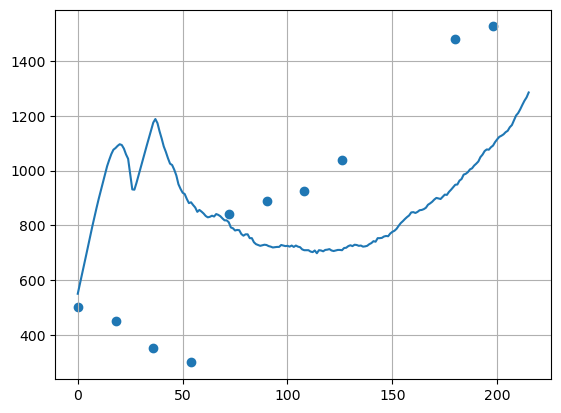

In [156]:
plt.plot(steps_inputs, output_vectors[minpos])
plt.scatter(quarters[::1], forensic_waitlist_len[::1])
plt.grid()
plt.show()

In [158]:
idx = np.argpartition(diffs, 10)

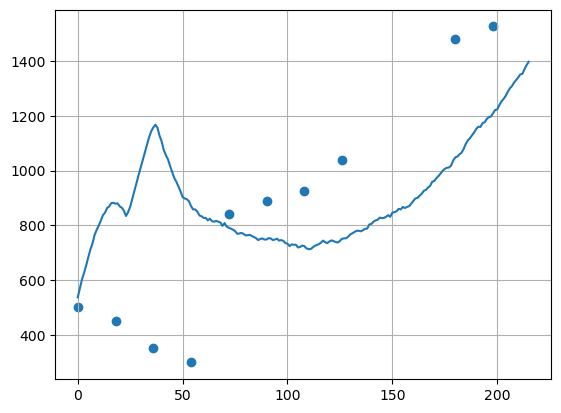

In [167]:
plt.plot(steps_inputs, output_vectors[idx[7]])
plt.scatter(quarters[::1], forensic_waitlist_len[::1])
plt.grid()
plt.show()

In [178]:
df1 = pd.DataFrame(output_vectors)

In [180]:
df1.to_csv("output_vecs.csv")

In [183]:
df2 = pd.DataFrame(input_params)
df2.to_csv("input_params.csv")

In [184]:
input_params = []
output_vectors = []
for i in range(0, 1000):
    print(i)
    civil_sd = max(0, np.random.normal(10, 5, 1))
    st_forensic_mean = max(0, np.random.normal(30, 10, 1))
    st_forensic_sd = max(0, np.random.normal(10, 5, 1))
    lt_forensic_sd = max(0, np.random.normal(10, 5, 1))
    vec = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, civil_sd, 
              st_forensic_mean, st_forensic_sd, 320, lt_forensic_sd)
    output_vectors.append(vec)
    input_params.append([civil_sd, st_forensic_mean, st_forensic_sd, lt_forensic_sd])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [185]:
diffs2 = [np.linalg.norm(vec - waitlist_imputed) for vec in output_vectors]
idx = np.argpartition(diffs, 10)

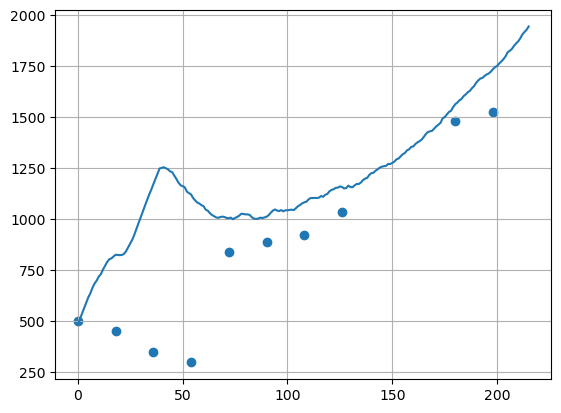

In [193]:
plt.plot(steps_inputs, output_vectors[idx[6]])
plt.scatter(quarters[::1], forensic_waitlist_len[::1])
plt.grid()
plt.show()

In [194]:
df1 = pd.DataFrame(output_vectors)
df1.to_csv("output_vecs_run2.csv")

In [195]:
df2 = pd.DataFrame(input_params)
df2.to_csv("input_params2.csv")

Initialize patient and treatment center arrays

In [120]:
Agent_Array = []        
    
TreatCent_Array = []
TreatCent_Array.append(TreatmentCenter(TreatID=0, Online_Capacity =170, Max_Capacity=263, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=1, Online_Capacity =131, Max_Capacity=144, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=2, Online_Capacity =51, Max_Capacity=71, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=3, Online_Capacity =160, Max_Capacity=220, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=4, Online_Capacity =189, Max_Capacity=268, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=5, Online_Capacity =169, Max_Capacity=262, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=6, Online_Capacity =20, Max_Capacity=32, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=7, Online_Capacity =52, Max_Capacity=52, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=8, Online_Capacity =178, Max_Capacity=288, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=9, Online_Capacity =193, Max_Capacity=262, waitlist=[], waitlistHistory=[]))
TreatCent_Array.append(TreatmentCenter(TreatID=10, Online_Capacity =170, Max_Capacity=305, waitlist=[], waitlistHistory=[]))

Prime the function with 2019 capacity and waitlist list data

hospitals should be full, and after the first step on Q1 2020 the waitlist should be 500.  33 are admitted on step 0 in 2020 and there arew

In [121]:
Agent_Array, TreatCent_Array, wait_1 = PatientTownSimForNSteps(Agent_Array, TreatCent_Array, [2000], 
                                                               1, (0.35/0.65), 'cost', False, (1-199/1689), 
                                                               8, 2, 50, 4, 320, 4)

In [122]:
wait_1

[517]

Run the simulation from Q1 of 2020

In [123]:
admits = forensic_admits_imputed.astype(int)
admits = [num for sublist in admits for num in sublist]

In [124]:
patients, treatment_centers, real_wait = PatientTownSimForNSteps(Agent_Array, TreatCent_Array, admits, 216, 
                                                                 (0.35/0.65), 'cost', False, (1-199/1689), 8, 2, 50, 
                                                                 4, 320, 4)

In [125]:
real_wait

[550,
 585,
 620,
 656,
 692,
 728,
 764,
 800,
 835,
 870,
 905,
 939,
 973,
 1007,
 1040,
 1073,
 1106,
 1138,
 1170,
 1202,
 1233,
 1264,
 1295,
 1325,
 1355,
 1385,
 1414,
 1443,
 1472,
 1500,
 1528,
 1556,
 1584,
 1611,
 1638,
 1665,
 1692,
 1719,
 1741,
 1765,
 1783,
 1799,
 1810,
 1805,
 1769,
 1728,
 1665,
 1596,
 1525,
 1530,
 1558,
 1586,
 1614,
 1642,
 1670,
 1698,
 1726,
 1754,
 1778,
 1763,
 1731,
 1705,
 1676,
 1638,
 1607,
 1587,
 1566,
 1549,
 1530,
 1531,
 1524,
 1527,
 1533,
 1547,
 1562,
 1574,
 1594,
 1603,
 1619,
 1633,
 1655,
 1675,
 1694,
 1720,
 1742,
 1766,
 1790,
 1812,
 1830,
 1847,
 1859,
 1872,
 1883,
 1889,
 1895,
 1897,
 1902,
 1894,
 1897,
 1903,
 1909,
 1910,
 1924,
 1931,
 1938,
 1945,
 1961,
 1969,
 1970,
 1977,
 1978,
 1983,
 1980,
 1979,
 1972,
 1963,
 1957,
 1951,
 1948,
 1948,
 1949,
 1958,
 1962,
 1961,
 1967,
 1982,
 1992,
 2005,
 2024,
 2039,
 2056,
 2071,
 2090,
 2100,
 2121,
 2143,
 2161,
 2176,
 2193,
 2214,
 2232,
 2253,
 2271,
 2281,
 2293

In [31]:
real_wait1 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait2 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait3 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait4 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait5 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait6 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait7 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait8 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait9 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait10 = runABCSim(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)

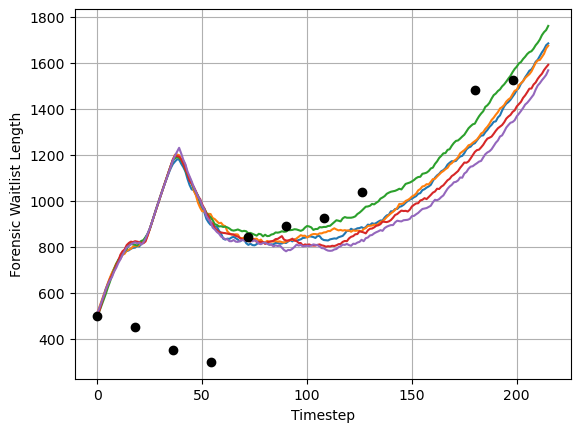

In [47]:
plt.plot(steps_inputs, real_wait1, zorder=2)
plt.plot(steps_inputs, real_wait2, zorder=3)
plt.plot(steps_inputs, real_wait3, zorder=4)
plt.plot(steps_inputs, real_wait4, zorder=5)
plt.plot(steps_inputs, real_wait5, zorder=6)
plt.scatter(quarters[::1], forensic_waitlist_len[::1], zorder=7, color="black")
plt.grid()
plt.xlabel('Timestep')
plt.ylabel('Forensic Waitlist Length')
plt.show()

In [48]:
def runABCSim_fullCapacity(admits, Timesteps, CivilForensicRatio, 
                            patientChoice, verbose, ST_percent, civil_mean, civil_sd, st_forensic_mean, 
                           st_forensic_sd, lt_forensic_mean, lt_forensic_sd):
    Agent_Array = []        
    TreatCent_Array = []
    TreatCent_Array.append(TreatmentCenter(TreatID=0, Online_Capacity =263, Max_Capacity=263, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=1, Online_Capacity =144, Max_Capacity=144, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=2, Online_Capacity =71, Max_Capacity=71, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=3, Online_Capacity =220, Max_Capacity=220, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=4, Online_Capacity =268, Max_Capacity=268, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=5, Online_Capacity =262, Max_Capacity=262, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=6, Online_Capacity =32, Max_Capacity=32, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=7, Online_Capacity =52, Max_Capacity=52, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=8, Online_Capacity =288, Max_Capacity=288, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=9, Online_Capacity =262, Max_Capacity=262, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=10, Online_Capacity =305, Max_Capacity=305, waitlist=[], waitlistHistory=[]))
    
    Agent_Array, TreatCent_Array, wait_1 = PatientTownSimForNSteps(Agent_Array, TreatCent_Array, [2000], 
                                                               1, CivilForensicRatio, 'cost', False, ST_percent, 
                                                               civil_mean, civil_sd, st_forensic_mean, 
                                                               st_forensic_sd, lt_forensic_mean, lt_forensic_sd)
    
    patients, treatment_centers, real_wait = PatientTownSimForNSteps(Agent_Array, TreatCent_Array, admits, Timesteps, 
                                                                CivilForensicRatio, 'cost', False, ST_percent, civil_mean, 
                                                                civil_sd, st_forensic_mean, st_forensic_sd, lt_forensic_mean, 
                                                                lt_forensic_sd)
    return real_wait

In [49]:
real_wait1 = runABCSim_fullCapacity(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait2 = runABCSim_fullCapacity(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait3 = runABCSim_fullCapacity(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait4 = runABCSim_fullCapacity(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait5 = runABCSim_fullCapacity(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)

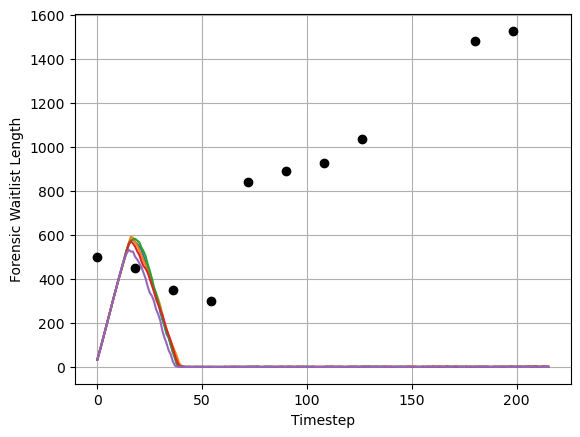

In [50]:
plt.plot(steps_inputs, real_wait1, zorder=2)
plt.plot(steps_inputs, real_wait2, zorder=3)
plt.plot(steps_inputs, real_wait3, zorder=4)
plt.plot(steps_inputs, real_wait4, zorder=5)
plt.plot(steps_inputs, real_wait5, zorder=6)
plt.scatter(quarters[::1], forensic_waitlist_len[::1], zorder=7, color="black")
plt.grid()
plt.xlabel('Timestep')
plt.ylabel('Forensic Waitlist Length')
plt.show()

In [51]:
def runABCSim_eightyCapMin(admits, Timesteps, CivilForensicRatio, 
                            patientChoice, verbose, ST_percent, civil_mean, civil_sd, st_forensic_mean, 
                           st_forensic_sd, lt_forensic_mean, lt_forensic_sd):
    Agent_Array = []        
    TreatCent_Array = []
    TreatCent_Array.append(TreatmentCenter(TreatID=0, Online_Capacity =210, Max_Capacity=263, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=1, Online_Capacity =131, Max_Capacity=144, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=2, Online_Capacity =57, Max_Capacity=71, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=3, Online_Capacity =176, Max_Capacity=220, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=4, Online_Capacity =215, Max_Capacity=268, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=5, Online_Capacity =210, Max_Capacity=262, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=6, Online_Capacity =26, Max_Capacity=32, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=7, Online_Capacity =52, Max_Capacity=52, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=8, Online_Capacity =230, Max_Capacity=288, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=9, Online_Capacity =210, Max_Capacity=262, waitlist=[], waitlistHistory=[]))
    TreatCent_Array.append(TreatmentCenter(TreatID=10, Online_Capacity =244, Max_Capacity=305, waitlist=[], waitlistHistory=[]))
    
    Agent_Array, TreatCent_Array, wait_1 = PatientTownSimForNSteps(Agent_Array, TreatCent_Array, [2000], 
                                                               1, CivilForensicRatio, 'cost', False, ST_percent, 
                                                               civil_mean, civil_sd, st_forensic_mean, 
                                                               st_forensic_sd, lt_forensic_mean, lt_forensic_sd)
    
    patients, treatment_centers, real_wait = PatientTownSimForNSteps(Agent_Array, TreatCent_Array, admits, Timesteps, 
                                                                CivilForensicRatio, 'cost', False, ST_percent, civil_mean, 
                                                                civil_sd, st_forensic_mean, st_forensic_sd, lt_forensic_mean, 
                                                                lt_forensic_sd)
    return real_wait

In [52]:
real_wait1 = runABCSim_eightyCapMin(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait2 = runABCSim_eightyCapMin(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait3 = runABCSim_eightyCapMin(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait4 = runABCSim_eightyCapMin(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)
real_wait5 = runABCSim_eightyCapMin(admits, 216, (0.35/0.65), 'cost', False, (1-199/1689), 8, 11.3, 
              30.1, 16.4, 320, 10.5)

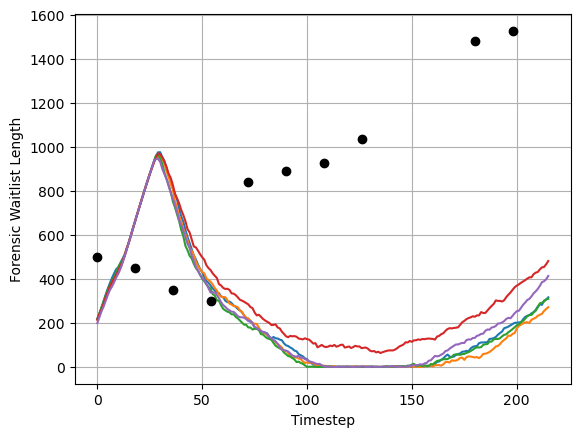

In [53]:
plt.plot(steps_inputs, real_wait1, zorder=2)
plt.plot(steps_inputs, real_wait2, zorder=3)
plt.plot(steps_inputs, real_wait3, zorder=4)
plt.plot(steps_inputs, real_wait4, zorder=5)
plt.plot(steps_inputs, real_wait5, zorder=6)
plt.scatter(quarters[::1], forensic_waitlist_len[::1], zorder=7, color="black")
plt.grid()
plt.xlabel('Timestep')
plt.ylabel('Forensic Waitlist Length')
plt.show()

In [3]:
%%python –version

UsageError: %%python is a cell magic, but the cell body is empty.


In [4]:
from platform import python_version

print(python_version())

3.10.9
